# Grid-Search on: <br> &emsp;Document Vectors using Cosine Similarity + RoBERTa

In [1]:
import os
from test_with_origin import restore_order
from ensemble_gs import ImdbSentimentClf, TrivialScaler, read_embeddings, read_logs

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import pickle
import json
import re
from typing import List
from original_to_1gram import normalize_text

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set(font_scale=1, style="whitegrid")

Finetune RoBERTa and extract RoBERTa embeddings with roberta/roberta.py before running this notebook!!!

!python roberta/roberta.py

## The Grid-Search Experiment
### Preparations

Because the 2 parts of docuemtn vectors were trained on different versions of the IMDB dataset (all from the original dataset but with different preprocessing and in different document orders), some auxilliary functions are needed to make sure that then are concatenated correctly.

In [2]:
def read_jsonl(path):
    ids = []
    texts = []
    labels = []
    with open(path, encoding='utf8') as f:
        for line in f:
            d = json.loads(line)
            ids.append(d['id'])
            texts.append(d['text'])
            labels.append(d['label'])
    return ids, texts, labels

def read_file(file_name:str, start_at:int, stop_before:int)->List[str]:
    '''
    read a part of the file: lines[start_at: stop_before]
    return the cleaned documents, for the purpose of restoring the order
    '''
    docs = []
    with open(file_name, encoding='utf8') as f:
        for i, line in enumerate(f):
            if i < start_at:
                continue
            if i == stop_before:
                break
            line = line[line.find(' ') + 1:]  # remove the index
            # in the 3gram file, "@$" is used as a word-separator inside tokens, 
            # so here remove every token with this separator (along with very few 
            # 1grams with "@$" to avoid interference)
            line = ''.join([t for t in line.lower().split(' ') if "@$" not in t])
            line = re.sub(r"<.{0,30}>", '', line)
            # due to different preprocessing for the 2 files, here only retain 
            # the alphabetics/'common symbols' in order to ignore noises and 
            # achieve exact matching (they are enough to retrieve the order). 
            line = re.sub(r"[^a-z,\.\?\!]", '', line)
            docs.append(line)     
    return docs

def restore_order(docs_1gram:List[str], docs_3gram:List[str], check=True)->np.ndarray:
    '''
    docs_1gram: docs returned by "read_file", read from the 1gram file
    docs_3gram: docs returned by "read_file", read from the 3gram file
    returns the matched order, with counting sort:
            argsort(docs_3gram, order=docs_1gram)
    '''
    n = len(docs_1gram)
    tri_dict = {}
    for i, doc in enumerate(docs_3gram):
        # repetitions exist in the dataset, so here use lists to deal with them
        tri_dict.setdefault(doc[:85], []).append(i)

    uni2tri = []
    for i, doc in enumerate(docs_1gram):
        uni2tri.append(tri_dict[doc[:85]].pop())

    uni2tri = np.array(uni2tri)
    if check:
        assert len(np.unique(uni2tri)) == len(uni2tri)  # no repetitions (valid permutation)
        #assert sum(uni2tri[:n//2] >= n//2) == 0  # positive remain positive
        #assert sum(uni2tri[n//2: n] < n//2) == 0  # negative remain negative
    return uni2tri


In [3]:
## read datasets from both sources and get a consistent ducument order
os.chdir("IMDB_splits")
trainset = read_jsonl("train.jsonl")
devset = read_jsonl("dev.jsonl")
testset = read_jsonl("test.jsonl")

os.chdir("../files_root")
docs_3gram = read_file("alldata-id_p3gram.txt", 0, 25000)
train_order = restore_order([re.sub(r"[^a-z,\.\?\!]", '', normalize_text(doc)) for doc in trainset[1]], docs_3gram)

#docs_1gram = read_file("alldata-id_p1gram.txt", 0, 25000)
docs_3gram = read_file("alldata-id_p3gram.txt", 0, 25000)
dev_order = restore_order([re.sub(r"[^a-z,\.\?\!]", '', normalize_text(doc)) for doc in devset[1]], docs_3gram)

#docs_1gram = read_file("alldata-id_p1gram.txt", 25000, 50000)
docs_3gram = read_file("alldata-id_p3gram.txt", 25000, 50000)
test_order = restore_order([re.sub(r"[^a-z,\.\?\!]", '', normalize_text(doc)) for doc in testset[1]], docs_3gram)
os.chdir("..")

In [4]:
## read embeddings from both sources and put them in a consistent docuemtn order
# read Document Vectors using Cosine Simialrity
embedding_train = read_embeddings('files_root/train_vectors.txt')
embedding_test = read_embeddings('files_root/test_vectors.txt')
# adjust the document order
embedding_dev = embedding_train[dev_order]
embedding_train = embedding_train[train_order]
embedding_test = embedding_test[test_order]
# get labels
y_train = np.array(trainset[2])
y_dev = np.array(devset[2])
y_test = np.array(testset[2])
# read RoBERTa embeddings
rembs_train = np.load("roberta/embs/emb_train.npy")
rembs_dev = np.load("roberta/embs/emb_dev.npy")
rembs_test = np.load("roberta/embs/emb_test.npy")

reading embeddings from files_root/train_vectors.txt
reading embeddings from files_root/test_vectors.txt


### Run the grid-search

In [5]:
# The grid of feature-wise scaling
dv_scalers = {
    'none': TrivialScaler(), 
    #'standard': StandardScaler(with_mean=False), 
    'standard_with_mean': StandardScaler(with_mean=True), 
}
re_scalers = {
    'none': TrivialScaler(), 
    'standard': StandardScaler(with_mean=True), 
    #'minmax': MaxAbsScaler(), 
}


In [6]:
# As in some cases the concatenation matrix is very baddly conditioned, the solver may not converge within the niter limit. 
# Here suppress the corresponding warnings to keep the stdout clean
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
np.random.seed(12)
# run the experiment
his = {}
rs = np.logspace(-7, 2, 10)
Cs = np.logspace(-7, 2, 10)
for dv_scaler_name, dv_scaler in dv_scalers.items():
    for bon_scaler_name, bon_scaler in re_scalers.items():
        stclf = ImdbSentimentClf(r=rs, C=Cs, dv_scaler=dv_scaler, bon_scaler=bon_scaler, cv=3)
        best = stclf.gridsearch(embedding_train, rembs_train, y_train, embedding_dev, rembs_dev, y_dev)
        test_name = f'dv_{dv_scaler_name}+rb_{bon_scaler_name}'
        his[test_name] = stclf.rec
        with open('test_logs/dv+roberta_logs.pkl', 'wb') as f:
            pickle.dump(his, f)
        print(test_name, best)


dv_none+rb_none {'C': 0.0001, 'r': 100.0, 'acc': 0.9576}
dv_none+rb_standard {'C': 0.0001, 'r': 100.0, 'acc': 0.9572}
dv_standard_with_mean+rb_none {'C': 0.0001, 'r': 100.0, 'acc': 0.9574}
dv_standard_with_mean+rb_standard {'C': 1e-05, 'r': 100.0, 'acc': 0.9578}


## The results

In [7]:
with open('test_logs/dv+roberta_logs.pkl', 'rb') as f:
    his = pickle.load(f)
df = read_logs(his)

In [8]:
df = df.rename(columns={"BON scaling": "RoBERTa scaling"})

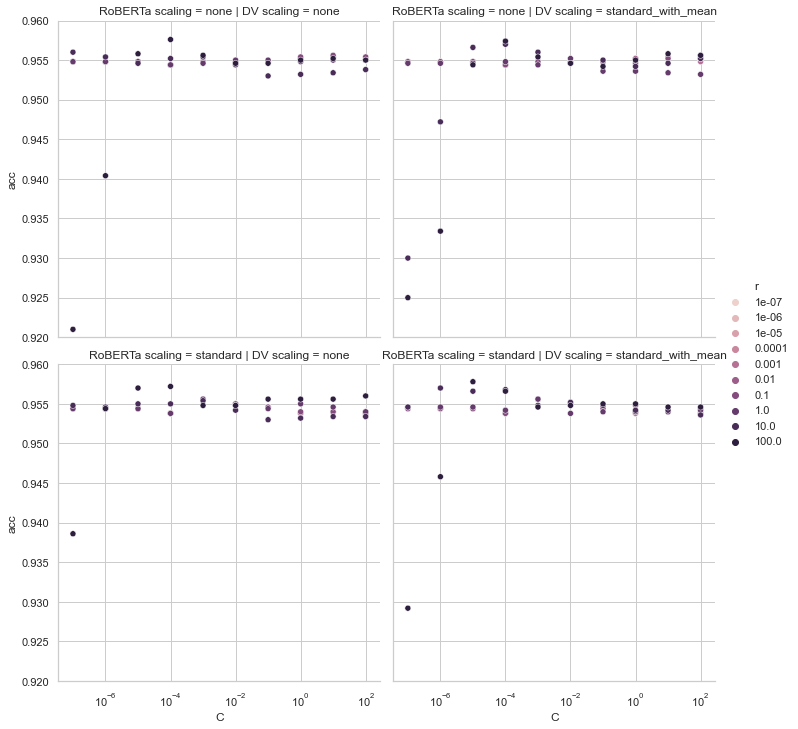

In [9]:
g = sns.relplot(x="C", y="acc", hue="r", col="DV scaling", row="RoBERTa scaling", data=df, hue_norm=LogNorm(1e-7, 1e2), legend="full")
g.set(xscale="log")
g.set(ylim=(0.92, 0.96))
g.savefig("figures/dv_rb_gs.jpg")

In [10]:
top = df.sort_values(by="acc", ascending=False).head(4).copy()
top

,C,r,acc,DV scaling,RoBERTa scaling
92,0.00001,100.0,0.9578,standard_with_mean,standard
93,0.00010,100.0,0.9576,none,none
93,0.00010,100.0,0.9574,standard_with_mean,none
93,0.00010,100.0,0.9572,none,standard


In [11]:
embedding_train = np.vstack([embedding_train, embedding_dev])
rembs_train = np.vstack([rembs_train, rembs_dev])

In [12]:
y_train = np.concatenate([y_train, y_dev])

In [13]:
lr = LogisticRegression()

sd = StandardScaler(with_mean=True)
embedding_train_sd = sd.fit_transform(embedding_train)
embedding_test_sd = sd.transform(embedding_test)

rembs_train_sd = sd.fit_transform(rembs_train)
rembs_test_sd = sd.transform(rembs_test)

for i, a in top.iterrows():
    dv_train = embedding_train_sd if a["DV scaling"] == "standard_with_mean" else embedding_train
    dv_test = embedding_test_sd if a["DV scaling"] == "standard_with_mean" else embedding_test

    rb_train = rembs_train_sd if a["RoBERTa scaling"] == "standard" else rembs_train
    rb_test = rembs_test_sd if a["RoBERTa scaling"] == "standard" else rembs_test

    lr.set_params(C=a["C"])
    lr.fit(np.hstack([dv_train * a["r"],rb_train]), y_train)
    test_score = lr.score(np.hstack([dv_test * a["r"], rb_test]), y_test)
    top.loc[i, "test score"] = test_score

top   

,C,r,acc,DV scaling,RoBERTa scaling,test score
92,0.00001,100.0,0.9578,standard_with_mean,standard,0.96072
93,0.00010,100.0,0.9576,none,none,0.95964
93,0.00010,100.0,0.9574,standard_with_mean,none,0.95964
93,0.00010,100.0,0.9572,none,standard,0.95964


In [14]:

lgcv = LogisticRegressionCV(Cs=np.logspace(-7, 4, 9), tol=0.001)
lgcv.fit(rembs_train, y_train)
rb_test_score = lgcv.score(rembs_test, y_test)

lgcv.fit(embedding_train, y_train)
dv_test_score = lgcv.score(embedding_test, y_test)
print("RoBERTa score:", rb_test_score)
print("dv score:", dv_test_score)

RoBERTa score: 0.95792
dv score: 0.9314


In [15]:
mag = []
mag.append({
    "name": "DV",
    "ndim": embedding_train.shape[1],
    "mean norm": np.linalg.norm(embedding_train, axis=-1).mean(),
    "mean norm avg": np.linalg.norm(embedding_train, axis=-1).mean()/embedding_train.shape[1],
})
mag.append({
    "name": "RoBERTa",
    "ndim": rembs_train.shape[1],
    "mean norm": np.linalg.norm(rembs_train, axis=-1).mean(),
    "mean norm avg":  np.linalg.norm(rembs_train, axis=-1).mean()/rembs_train.shape[1]
})
pd.DataFrame.from_records(mag, index="name")

,ndim,mean norm,mean norm avg
name,,,
DV,500,5.367574,0.010735
RoBERTa,768,14.571285,0.018973
